In [1]:
import re
import json

In [2]:
from gensim.models import Word2Vec

model = Word2Vec.load("/kaggle/input/word2vec-large-2/word2vec_model_LARGE_2.bin")

In [3]:
def get_average_word2vec(sentence):
    word_vectors = []
    for word in sentence.split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
x = train_df['text']
y = train_df['label']

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.5 MB/s eta 0:00:00


In [6]:
import contractions
def handle_punctuation(text):
    # Expand contractions
    text = contractions.fix(text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)

    return text

new_x = []
for i, text in enumerate(x):
    new_text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    new_x.append(handle_punctuation(new_text))
x = new_x

import json
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))

new_x = []
for text in x:
  words = text.split()
  corrected_slang_words = []
  for word in words:
    if word in slang_dict:
      word = slang_dict[word].lower()
    corrected_slang_words.append(word)

  new_x.append(' '.join(corrected_slang_words))

x = new_x

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.15, random_state = 2022)

In [8]:
# Assuming you have a list of sentences and their corresponding labels
sentences = x_train  # List of sentences
labels = y_train  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [9]:
# Convert sentences to their corresponding Word2Vec embeddings
sentence_vectors = []
for sentence in sentences:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    sentence_vectors.append(vector)

sentence_vectors = np.array(sentence_vectors)

In [10]:
# Convert sentences to their corresponding Word2Vec embeddings
val_sentence_vectors = []
for sentence in x_val:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    val_sentence_vectors.append(vector)

val_sentence_vectors = np.array(val_sentence_vectors)

In [11]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


Radial Basis Function(RBF) kernel is needed when the data is really unevenly distributed. So we use poly kernel.

In [12]:
poly = svm.SVC(kernel='poly', degree=3, C=1,verbose=True).fit(sentence_vectors[:65000], labels[:65000])

[LibSVM]...........*..*.*
optimization finished, #iter = 13823
obj = -14637.241142, rho = -0.844666
nSV = 15609, nBSV = 15181
.......*..*.*
optimization finished, #iter = 9405
obj = -7744.039311, rho = -0.269098
nSV = 8889, nBSV = 8493
....
*..*
optimization finished, #iter = 6006
obj = -4465.473865, rho = -0.633883
nSV = 5579, nBSV = 5228
....*.*.*
optimization finished, #iter = 5763
obj = -3806.624718, rho = -0.075940
nSV = 4848, nBSV = 4522
............*.
*.*
optimization finished, #iter = 14435
obj = -16088.882707, rho = 1.027395
nSV = 17192, nBSV = 16766
........*.*
optimization finished, #iter = 9482
obj = -8536.812691, rho = 0.719639
nSV = 9873, nBSV = 9500
.....*.*
optimization finished, #iter = 6405
obj = -5492.025257, rho = 0.934755
nSV = 6671, nBSV = 6338
............*.*
optimization finished, #iter = 13820
obj = -16299.600256, rho = 0.282674
nSV = 17448, nBSV = 16969
........*..*.*
optimization finished, #iter = 10879
obj = -9115.197410, rho = 0.720638
nSV = 10322, nBSV = 9

In [16]:
from joblib import dump, load
dump(poly, 'svm_65k.joblib') 

['svm_65k.joblib']

In [17]:
y_pred_test = poly.predict(val_sentence_vectors[:10000])

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [19]:
# Calculate Accuracy
accuracy = accuracy_score(y_val[:10000], y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val[:10000], y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

f1_score = f1_score(y_val[:10000], y_pred_test, average='weighted')
print('F1 (Polynomial Kernel): ', "%.2f" % (f1_score*100))

Accuracy: 0.5783
Confusion Matrix:
 [[1468  440   64   14   27]
 [ 460 1010  421   59   32]
 [  95  446  950  402   61]
 [  31   83  451 1098  417]
 [  31   52   97  534 1257]]
F1 (Polynomial Kernel):  57.90


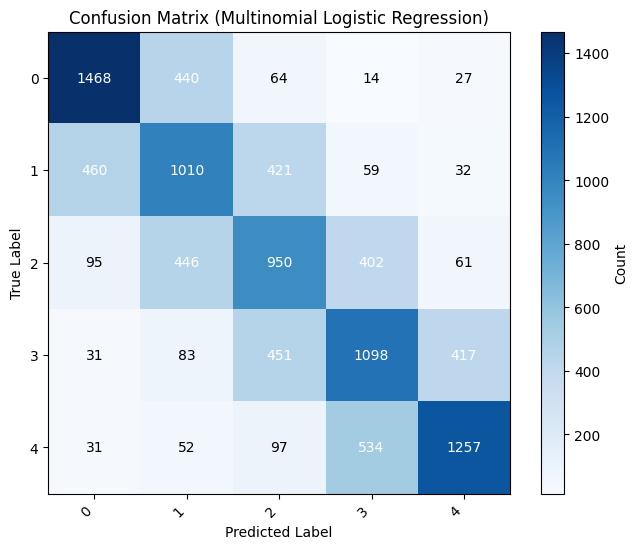

In [21]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(5)]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()